### Playground

A playground for experimenting with the alt-likelihood models

In [59]:
%load_ext autoreload
%autoreload 2
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from models import VarTGP, VarGP, ExactGP, VarLGP, VarSGP
from utils import set_seeds, TorchStandardScaler, TorchNormalizer, get_prediction_summary
from optim import train_exact_model_botorch, train_natural_variational_model
from botorch.acquisition import LogExpectedImprovement

colors = ["#003f5c", "#7a5195", "#ef5675", "#ffa600"]

# Setup
set_seeds(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# Generate data
n_train = 40
n_test = 200

num_outliers = 15

# Generate 1D synthetic data with outliers
def target_function(x):
    return np.sin(10 * x) * np.exp(-2 * x) + 0.2 * np.sin(25 * x)

x_train = torch.rand(n_train).unsqueeze(-1).double()
y_train = torch.tensor([target_function(x.item()) for x in x_train]).double()

outlier_idx = np.random.choice(n_train, num_outliers, replace=False)
y_train[outlier_idx] += -1*torch.randn(num_outliers).abs()

x_test = torch.linspace(0, 1, n_test).unsqueeze(-1).double()
y_test = torch.tensor([target_function(x.item()) for x in x_test]).double()

# Normalize X data to [0,1] range and standardize Y data
x_normalizer = TorchNormalizer()
x_train = x_normalizer.fit_transform(x_train)
x_test = x_normalizer.transform(x_test)

y_scaler = TorchStandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

SkewNormal(loc: torch.Size([2, 200]), scale: torch.Size([2, 200]), shape: torch.Size([2, 200]))


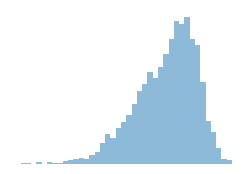

Learned shape parameter (skewness): -4.1641


In [56]:
inducing_points = x_train.clone()
model = VarSGP(inducing_points, goal=None).double()
train_natural_variational_model(
    model, x_train, y_train, epochs=600, lr=0.01, y_standardize=True
)

model.eval()
with torch.no_grad():
    posterior = model.posterior(x_test, num_samples=2)

# confirm that the posterior is of the distribution type and shape we expect
print(posterior)
samples = posterior.rsample(torch.Size([2000]))
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
plt.hist(samples.detach().numpy()[:,0,0], bins=40, alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.gca().spines[:].set_visible(False)
plt.show()

print(f"Learned shape parameter (skewness): {model.likelihood.shape.item():.4f}")

In [40]:
# Clone inducing points and initialize model
inducing_points = x_train.clone()
model = VarTGP(inducing_points).double()

# Train model
train_natural_variational_model(
    model, x_train, y_train, epochs=600, lr=0.01, y_standardize=True
)

# Best observed value
best_f = y_train.max()

# Number of MC and likelihood samples
num_lik_samples = 1024
num_mc_samples = 1024

# Get posterior and draw samples
model.eval()
with torch.no_grad():
    posterior = model.posterior(x_test, num_samples=num_lik_samples)
    samples = posterior.sample(torch.Size([num_mc_samples]))  # Shape: [num_mc_samples, num_lik_samples, n_test]
    samples = samples.reshape(-1, posterior.batch_shape[1])   # Shape: [num_mc_samples * num_lik_samples, n_test]

# Compute Expected Improvement
improvement = (samples - best_f).clamp(min=0)
expected_improvement = np.log(improvement+1e-12).mean(dim=0).squeeze()

print("done")

# mean, _, lower, upper = get_prediction_summary(posterior, num_samples=256)


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    posterior = model.posterior(x_test, num_samples=num_lik_samples, observation_noise=False)
    samples = posterior.sample(torch.Size([40000]))  # Shape: [num_mc_samples, num_lik_samples, n_test]
    # samples = samples.reshape(-1, posterior.batch_shape[1])   # Shape: [num_mc_samples * num_lik_samples, n_test]

# Compute Expected Improvement
improvement = (samples - best_f).clamp(min=0)
expected_improvement_g = np.log(improvement+1e-12).mean(dim=0).squeeze()

print("done")

mean, _, lower, upper = get_prediction_summary(posterior, num_samples=256)

done
MultivariateNormal likelihood detected, sampling accordingly.


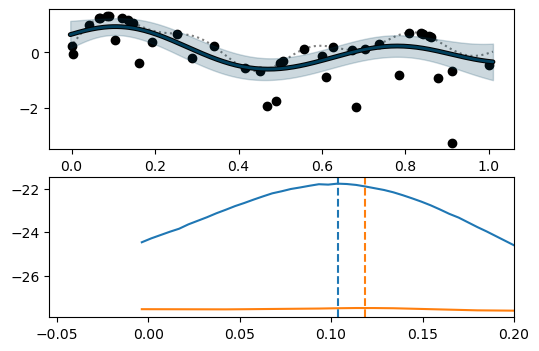

In [ ]:
# Plot
fig, ax = plt.subplots(nrows=2, figsize=(6, 4))

ax[0].plot(x_test, y_test, color="grey", ls=":", zorder=-1)
ax[0].scatter(x_train, y_train, color="k")

ax[0].plot(x_test, mean, color='k', lw=3.5, solid_capstyle='round')
ax[0].plot(x_test, mean, color=colors[0], lw=2, solid_capstyle='round')

ax[0].fill_between(
    x_test.flatten(),
    lower,
    upper,
    alpha=0.2,
    # label="95% confidence interval",
    color=colors[0],
)


ax[1].plot(x_test.numpy(), expected_improvement.numpy())
ax[1].plot(x_test.numpy(), expected_improvement_g.numpy())

ax[1].axvline(x_test[torch.argmax(expected_improvement)].item(), color='C0', ls='--')
ax[1].axvline(x_test[torch.argmax(expected_improvement_g)].item(), color='C1', ls='--')
ax[1].set_xlim(None, 0.2)
plt.show()


### Train and predict with all models

StudentT likelihood detected, sampling accordingly.
Laplace likelihood detected, sampling accordingly.
SkewNormal likelihood detected, sampling accordingly.
MultivariateNormal likelihood detected, sampling accordingly.


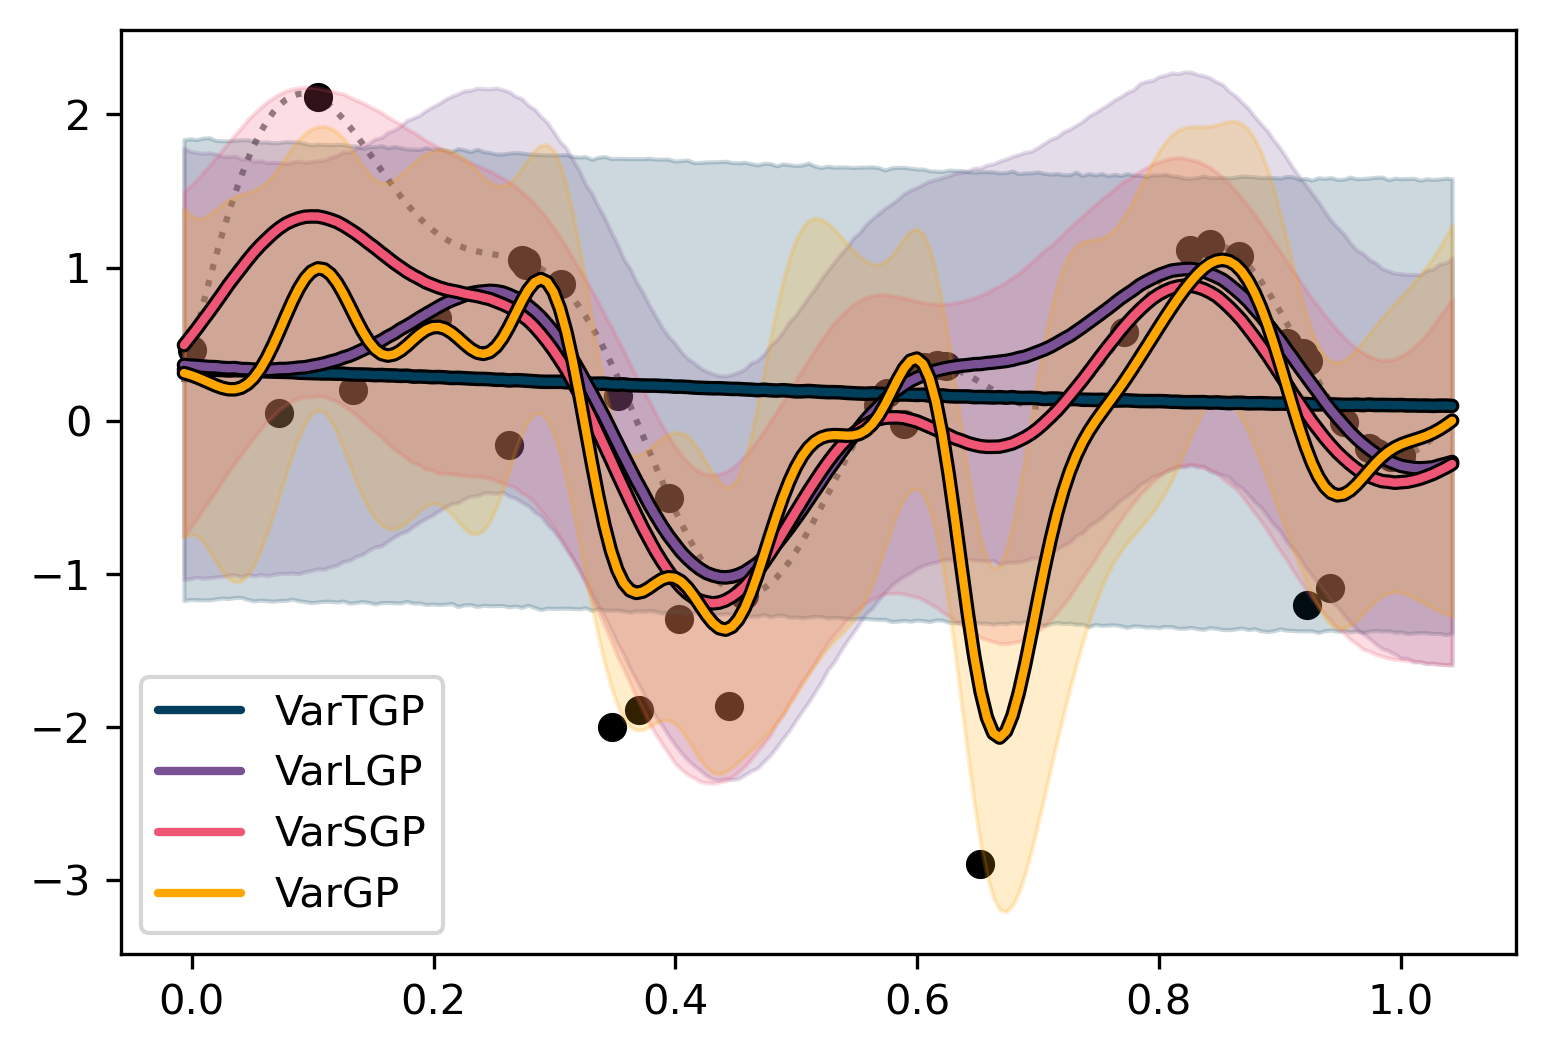

In [61]:
model_classes = [VarTGP, VarLGP, VarSGP, VarGP]
model_names = ["VarTGP", "VarLGP", "VarSGP", "VarGP"]
colors = ["#003f5c", "#7a5195", "#ef5675", "#ffa600"]

plt.figure(figsize=(6, 4), dpi=300)
plt.plot(x_test, y_test, color="grey", ls=":", zorder=-1)
plt.scatter(x_train, y_train, color="k")

for i, model_class in enumerate(model_classes):

    inducing_points = x_train.clone()
    model = model_class(inducing_points).double()
    train_natural_variational_model(
        model, x_train, y_train, epochs=600, lr=0.01, y_standardize=True
    )

    model.eval()
    with torch.no_grad():
        posterior = model.posterior(x_test, num_samples=256, observation_noise=True)
    
    mean, _, lower, upper = get_prediction_summary(posterior, num_samples=1024)

    plt.plot(x_test, mean, color='k', lw=3.5, solid_capstyle='round')
    plt.plot(x_test, mean, color=colors[i], lw=2, label=model_names[i], solid_capstyle='round')

    plt.fill_between(
        x_test.flatten(),
        lower,
        upper,
        alpha=0.2,
        # label="95% confidence interval",
        color=colors[i],
    )

plt.legend()
plt.show()

SkewNormal likelihood detected, sampling accordingly.


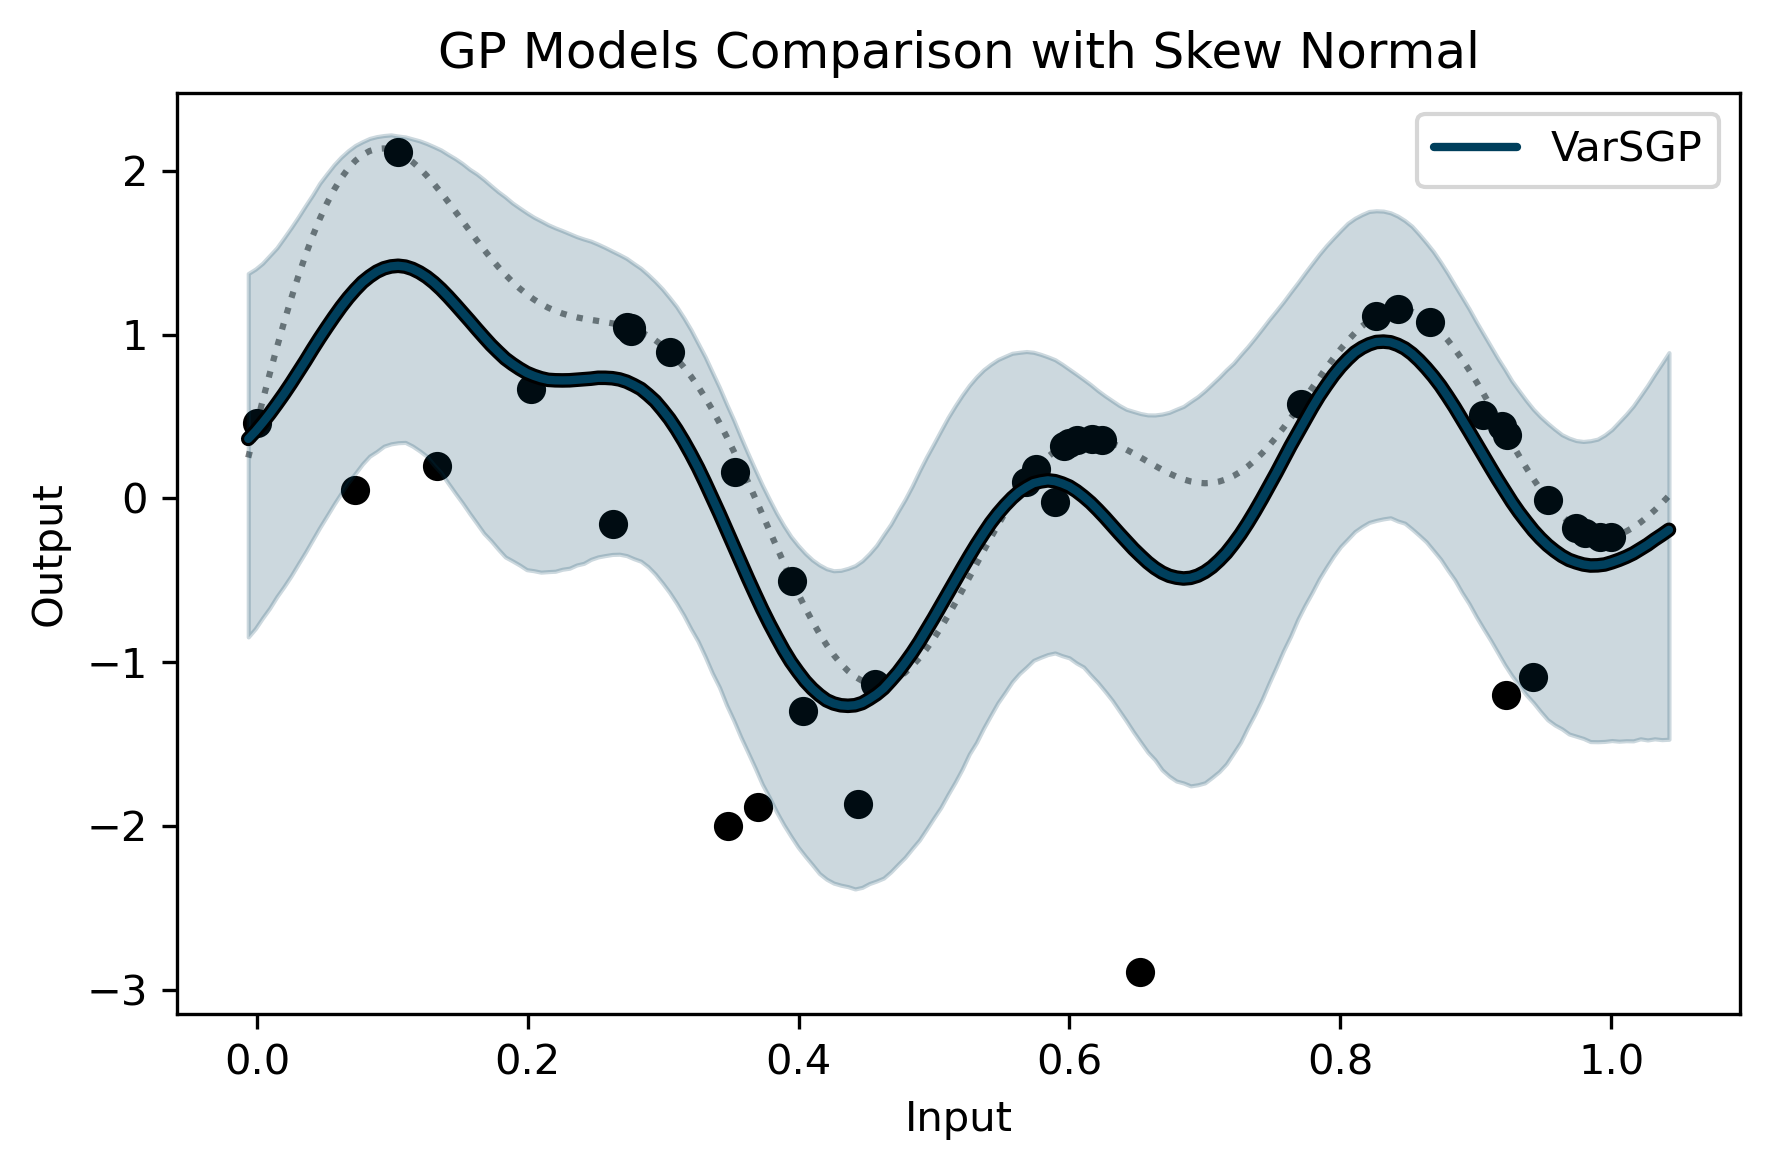

Learned shape parameter (skewness): -4.1572
Learned shape parameter (skewness): 0.6976


In [57]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Add model to list
model_classes = [VarSGP]
model_names = ["VarSGP"]
colors = ["#003f5c", "#7a5195", "#ef5675", "#ffa600"]

plt.figure(figsize=(6, 4), dpi=300)
plt.plot(x_test, y_test, color="grey", ls=":", zorder=-1)
plt.scatter(x_train, y_train, color="k")

for i, model_class in enumerate(model_classes):
    inducing_points = x_train.clone()
    model = model_class(inducing_points).double()
    train_natural_variational_model(
        model, x_train, y_train, epochs=600, lr=0.01, y_standardize=True
    )

    model.eval()
    with torch.no_grad():
        posterior = model.posterior(x_test, num_samples=256, observation_noise=True)
    
    mean, _, lower, upper = get_prediction_summary(posterior, num_samples=1024)

    plt.plot(x_test, mean, color='k', lw=3.5, solid_capstyle='round')
    plt.plot(x_test, mean, color=colors[i], lw=2, label=model_names[i], solid_capstyle='round')

    plt.fill_between(
        x_test.flatten(),
        lower,
        upper,
        alpha=0.2,
        color=colors[i],
    )

plt.legend()
plt.title("GP Models Comparison with Skew Normal")
plt.xlabel("Input")
plt.ylabel("Output")
plt.tight_layout()
plt.show()

# To inspect the skewness parameter

print(f"Learned shape parameter (skewness): {model.likelihood.shape.item():.4f}")
print(f"Learned shape parameter (skewness): {model.likelihood.scale.item():.4f}")

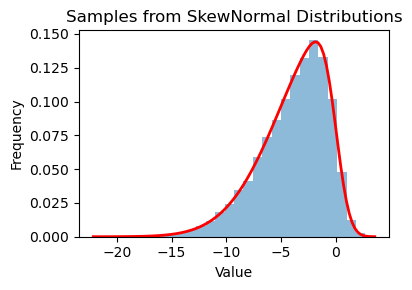

In [ ]:
import torch
import matplotlib.pyplot as plt
from skewnorm import SkewNormal, SkewNormalLikelihood
from scipy.stats import skewnorm

# Set random seed for reproducibility
torch.manual_seed(123)

loc = torch.tensor(0.0)
scale = torch.tensor(5.0)
a = torch.tensor(-5.0)
n_samples = 15000


sknorm = SkewNormal(loc, scale, a)
samples = sknorm.rsample((n_samples,))

x = torch.linspace(samples.min(), samples.max(), 100)
pdf = skewnorm.pdf(x, a.numpy(), loc=loc.numpy(), scale=scale.numpy())

# Plot histograms
plt.figure(figsize=(4,3))

plt.hist(samples.numpy(), alpha=0.5, bins=30, density=True)
plt.plot(x.numpy(), pdf, color='red', lw=2, label='SkewNormal PDF')

plt.title('Samples from SkewNormal Distributions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


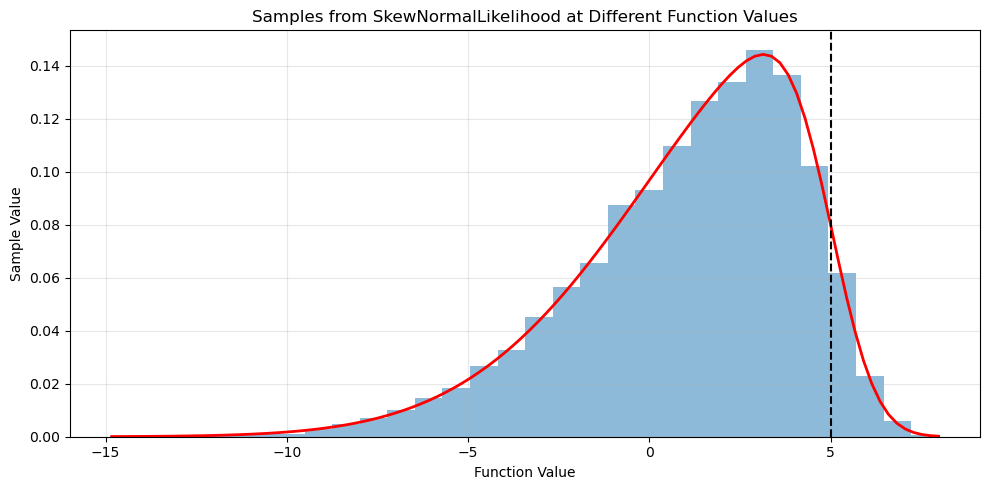

In [ ]:
loc = torch.tensor(5.0)
scale = torch.tensor(5.0)
a = torch.tensor(-5.0)


# Example with SkewNormalLikelihood for GPyTorch
likelihood = SkewNormalLikelihood()
likelihood.initialize(scale=scale.item(), shape=a.item())

# Generate some GP function values (normally this would come from a GP model)
function_values = loc.view(-1, 1)

# Get distributions from likelihood
distribution = likelihood(function_values)

# Draw samples at each function value
num_samples = 10000
likelihood_samples = distribution.rsample((num_samples,))

x = torch.linspace(likelihood_samples.min(), likelihood_samples.max(), 100)
pdf = skewnorm.pdf(x, a.numpy(), loc=loc.numpy(), scale=scale.numpy())

# Plot the samples
plt.figure(figsize=(10, 5))
plt.hist(likelihood_samples.detach().numpy().flatten(), bins=30, alpha=0.5, density=True)
plt.plot(x.numpy(), pdf, color='red', lw=2, label='SkewNormal PDF')
plt.axvline(loc.item(), color='k', linestyle='--', label='Function Value')
plt.title('Samples from SkewNormalLikelihood at Different Function Values')
plt.xlabel('Function Value')
plt.ylabel('Sample Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()